## Compare the return period of the 25-, 50-, and 100-year floods in GEV vs. Gumbel. Same sensitivity?

In [4]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import random as rand
import multiprocessing
import cartopy
import os.path
from joblib import Parallel, delayed
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r as gumbel
from netCDF4 import Dataset
from datetime import datetime



In [2]:
## --- Read in data --- ##
CaMaFile = Dataset('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/fldare1161.nc')
lat =  CaMaFile.variables['lat'][:] 
lon = CaMaFile.variables['lon'][:] 

#matData   = sio.loadmat('/Users/meganfowler/Documents/MATLAB/FloodProject/CaMaFlood/Physiology/30yr/control_outflw.mat')

matData   = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/control_outflw.mat')
maxYearly = matData['maxYearly_full']

fullData   = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/full_outflw.mat')
fullYearly = fullData['maxYearly_full']

physData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/physiology_outflw.mat')
physYearly = physData['maxYearly_full']

radData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/radiation_outflw.mat')
radYearly = radData['maxYearly_full']



In [4]:
print(np.shape(fullYearly))
print(np.shape(lon))

(1440, 720, 30)
(1440,)


In [7]:
## ----- Create a netCDF file with all data ------- ##  

#Save everything out to a netCDF file to use NCL with 
f = Dataset('/gdata/pritchard2/mdfowler/Flooding-physiology/annMaxDischarges_1.nc','w',format='NETCDF4')

#Write out CESM1-based discharge data
FULLgrp = f.createGroup('FULL')
FULLgrp.createDimension('lon',len(lon))
FULLgrp.createDimension('lat',len(lat))
FULLgrp.createDimension('time',30)
longitude = FULLgrp.createVariable('Longitude','f4','lon')
latitude  = FULLgrp.createVariable('Latitude','f4','lat')
annMaxFULL = FULLgrp.createVariable('Ann_max_discharge_FULL','f4',('lon','lat','time'))
longitude[:] = lon
latitude[:]  = lat
#Set blank value to -999
fullYearly[np.where(np.isnan(fullYearly)==True)]=-999
annMaxFULL[:,:,:] = fullYearly
#Add global attributes
f.description = "Annual maximum river discharges from CaMa, originally saved as .mat files"
today = datetime.today()
f.history = "Created " + today.strftime("%d/%m/%y")

#Add CTRL group 
CTRLgrp = f.createGroup('CTRL')
CTRLgrp.createDimension('lon',len(lon))
CTRLgrp.createDimension('lat',len(lat))
CTRLgrp.createDimension('time',30)
longitude = CTRLgrp.createVariable('Longitude','f4','lon')
latitude  = CTRLgrp.createVariable('Latitude','f4','lat')
annMaxCTRL = CTRLgrp.createVariable('Ann_max_discharge_CTRL','f4',('lon','lat','time'))
longitude[:] = lon
latitude[:]  = lat
#Set blank value to -999
maxYearly[np.where(np.isnan(maxYearly)==True)]=-999
annMaxCTRL[:,:,:] = maxYearly

#Add PHYS group 
PHYSgrp = f.createGroup('PHYS')
PHYSgrp.createDimension('lon',len(lon))
PHYSgrp.createDimension('lat',len(lat))
PHYSgrp.createDimension('time',30)
longitude = PHYSgrp.createVariable('Longitude','f4','lon')
latitude  = PHYSgrp.createVariable('Latitude','f4','lat')
annMaxPHYS = PHYSgrp.createVariable('Ann_max_discharge_PHYS','f4',('lon','lat','time'))
longitude[:] = lon
latitude[:]  = lat
#Set blank value to -999
physYearly[np.where(np.isnan(physYearly)==True)]=-999
annMaxPHYS[:,:,:] = physYearly

#Add RAD group 
RADgrp = f.createGroup('RAD')
RADgrp.createDimension('lon',len(lon))
RADgrp.createDimension('lat',len(lat))
RADgrp.createDimension('time',30)
longitude = RADgrp.createVariable('Longitude','f4','lon')
latitude  = RADgrp.createVariable('Latitude','f4','lat')
annMaxRAD = RADgrp.createVariable('Ann_max_discharge_RAD','f4',('lon','lat','time'))
longitude[:] = lon
latitude[:]  = lat
#Set blank value to -999
radYearly[np.where(np.isnan(radYearly)==True)]=-999
annMaxRAD[:,:,:] = radYearly


In [12]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(27,30,72), (62,86,170), (81,144,208), (104,200,220),(166,227,221), 
           (221,238,247), (248,247,100),(250,203,0),(249,81,1), (246,80,149),(242,30,15)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

In [4]:
def computeGumbel(recArray,recFullArr,recPhysArr,recRadArr,i):
    
    if np.remainder(i,100)==0:
        print(i) 
    
    #print(len(lat))
    
    TfullInt = np.full([len(lat)],np.nan)
    TphysInt = np.full([len(lat)],np.nan)
    TradInt = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]
        recFull = recFullArr[j,:]
        recPhys = recPhysArr[j,:]
        recRad  = recRadArr[j,:]
       
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            gumbel_fit = gumbel.fit(rec)
            M = gumbel_fit[0]
            S = gumbel_fit[1]
    
            #Compute discharge of 100-year flood 
            R100 = gumbel.ppf((1-(1/retPeriod)),loc=M,scale=S)
            # Imagine we have the PDF for the gumbel fit of flood magnitude
            # R100 is the flood magnitude corresopnding to 99% probability i.e.
            # Inverting the CDF at 0.99
            # i.e. 1-CDF = 0.01 (definition of the 100 year flood)
            # Analogous to tinv (0.99,dof) in matlab inversion of t-distribution.
            # So if rec --> 100*rec, R100 --> 100*R100
    
            #Compute fit for CO2 experiments
            gumbelFull = gumbel.fit(recFull)
            gumbelPhys = gumbel.fit(recPhys)
            gumbelRad  = gumbel.fit(recRad)
    
            cdfFull = gumbel.cdf(R100,*gumbelFull)    #Compute CDF at the point of R100 
            cdfPhys = gumbel.cdf(R100,*gumbelPhys)
            cdfRad  = gumbel.cdf(R100,*gumbelRad)
            # Let's suppose the PDF shifts to the right. 
            # Then the same magnitude flood from R100 would be more likely to occur
            # I.e more of the tail is to the right of R100
            # So CDF of the new fitted distribution evaluated at the old R100 will be < 0.99 
            # And 1-CDF is the boost in the tail to the right of R100.
            # It might be more like 4/100 
            # The inverse of that (100/4) says the 100 year flood happens every 25 years.
    
            TfullInt[j] = 1/(1-cdfFull)    #Return Period 
            TphysInt[j] = 1/(1-cdfPhys)
            TradInt[j]  = 1/(1-cdfRad)
            
    Tfull = TfullInt
    Tphys = TphysInt
    Trad  = TradInt
    
    return Tfull, Tphys, Trad

In [8]:
def computeGEV(recArray,recFullArr,recPhysArr,recRadArr,i):
    
    if np.remainder(i,100)==0:
        print(i) 
    
    #print(len(lat))
    
    TfullInt = np.full([len(lat)],np.nan)
    TphysInt = np.full([len(lat)],np.nan)
    TradInt = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]
        recFull = recFullArr[j,:]
        recPhys = recPhysArr[j,:]
        recRad  = recRadArr[j,:]
       
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            gev_fit = gev.fit(rec)
            M = gev_fit[1]
            S = gev_fit[2]
    
            #Compute discharge of 100-year flood 
            R100 = gev.ppf((1-(1/retPeriod)),*gev_fit)
    
            #Compute fit for CO2 experiments
            gevFull = gev.fit(recFull)
            gevPhys = gev.fit(recPhys)
            gevRad  = gev.fit(recRad)
    
            cdfFull = gev.cdf(R100,*gevFull)    #Compute CDF at the point of R100 
            cdfPhys = gev.cdf(R100,*gevPhys)
            cdfRad  = gev.cdf(R100,*gevRad)
    
            TfullInt[j] = 1/(1-cdfFull)    #Return Period 
            TphysInt[j] = 1/(1-cdfPhys)
            TradInt[j]  = 1/(1-cdfRad)
            
    Tfull = TfullInt
    Tphys = TphysInt
    Trad  = TradInt
    
    return Tfull, Tphys, Trad

In [21]:
# -- Compute Gumbel based flood return period -- #

Tfull_25Gumbel = np.full([len(lon),len(lat)],np.nan)
Tphys_25Gumbel = np.full([len(lon),len(lat)],np.nan)
Trad_25Gumbel  = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly*(1e9)/86400 #In m^3/s 
recFull = fullYearly*(1e9)/86400 #In m^3/s 
recPhys = physYearly*(1e9)/86400 #In m^3/s 
recRad  = radYearly*(1e9)/86400 #In m^3/s 

retPeriod = 25.0  #Return period

Tbig = Parallel(n_jobs=10)(delayed(computeGumbel)(rec[i,:,:],recFull[i,:,:],recPhys[i,:,:],recRad[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull_25Gumbel[i,:] = Tbig[i][0]
    Tphys_25Gumbel[i,:] = Tbig[i][1]
    Trad_25Gumbel[i,:]  = Tbig[i][2]



0


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


100


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


200


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


300


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


400


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2669: RuntimeWarning: overflow encountered in exp
  return -x - np.exp(-x)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


500


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


600


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


700
800


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


900
1000
1100
1200
1300
1400


In [22]:
# -- Compute GEV based flood return period -- #

Tfull_25GEV = np.full([len(lon),len(lat)],np.nan)
Tphys_25GEV = np.full([len(lon),len(lat)],np.nan)
Trad_25GEV  = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly*(1e9)/86400 #In m^3/s 
recFull = fullYearly*(1e9)/86400 #In m^3/s 
recPhys = physYearly*(1e9)/86400 #In m^3/s 
recRad  = radYearly*(1e9)/86400 #In m^3/s 

retPeriod = 25.0  #Return period

Tbig = Parallel(n_jobs=10)(delayed(computeGEV)(rec[i,:,:],recFull[i,:,:],recPhys[i,:,:],recRad[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull_25GEV[i,:] = Tbig[i][0]
    Tphys_25GEV[i,:] = Tbig[i][1]
    Trad_25GEV[i,:]  = Tbig[i][2]




0


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/mdfowler/anaco

100
200


/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


300


/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


400


/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


500


/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


600
700
800


/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


900
1000
1100
1200
1300
1400


## Plotting 

In [23]:
# Define array of colors for maps - GUMBEL 25 year return period

colorsFull_25Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>=1)  & (Tfull_25Gumbel<=3))]   = 1
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>3)   & (Tfull_25Gumbel<=7))]   = 2
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>7)  & (Tfull_25Gumbel<=12))]   = 3
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>12)  & (Tfull_25Gumbel<=18))]  = 4
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>18)  & (Tfull_25Gumbel<=20))]  = 5
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>20)  & (Tfull_25Gumbel<=30))]  = 6
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>30) & (Tfull_25Gumbel<=40))]   = 7
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>40) & (Tfull_25Gumbel<=50))]   = 8
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>50) & (Tfull_25Gumbel<=75))]   = 9
colorsFull_25Gumbel[np.where((Tfull_25Gumbel>75) & (Tfull_25Gumbel<=100))]  = 10
colorsFull_25Gumbel[np.where(Tfull_25Gumbel>100)]                        = 11

colorsRad_25Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsRad_25Gumbel[np.where((Trad_25Gumbel>=1)  & (Trad_25Gumbel<=3))]     = 1
colorsRad_25Gumbel[np.where((Trad_25Gumbel>3)   & (Trad_25Gumbel<=7))]    = 2
colorsRad_25Gumbel[np.where((Trad_25Gumbel>7)  & (Trad_25Gumbel<=12))]    = 3
colorsRad_25Gumbel[np.where((Trad_25Gumbel>12)  & (Trad_25Gumbel<=18))]    = 4
colorsRad_25Gumbel[np.where((Trad_25Gumbel>18)  & (Trad_25Gumbel<=20))]    = 5
colorsRad_25Gumbel[np.where((Trad_25Gumbel>20)  & (Trad_25Gumbel<=30))]   = 6
colorsRad_25Gumbel[np.where((Trad_25Gumbel>30) & (Trad_25Gumbel<=40))]   = 7
colorsRad_25Gumbel[np.where((Trad_25Gumbel>40) & (Trad_25Gumbel<=50))]   = 8
colorsRad_25Gumbel[np.where((Trad_25Gumbel>50) & (Trad_25Gumbel<=75))]   = 9
colorsRad_25Gumbel[np.where((Trad_25Gumbel>75) & (Trad_25Gumbel<=100))]  = 10
colorsRad_25Gumbel[np.where(Trad_25Gumbel>100)]                      = 11

colorsPhys_25Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>=1)  & (Tphys_25Gumbel<=3))]     = 1
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>3)   & (Tphys_25Gumbel<=7))]    = 2
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>7)  & (Tphys_25Gumbel<=12))]    = 3
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>12)  & (Tphys_25Gumbel<=18))]    = 4
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>18)  & (Tphys_25Gumbel<=20))]    = 5
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>20)  & (Tphys_25Gumbel<=30))]   = 6
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>30) & (Tphys_25Gumbel<=40))]   = 7
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>40) & (Tphys_25Gumbel<=50))]   = 8
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>50) & (Tphys_25Gumbel<=75))]   = 9
colorsPhys_25Gumbel[np.where((Tphys_25Gumbel>75) & (Tphys_25Gumbel<=100))]  = 10
colorsPhys_25Gumbel[np.where(Tphys_25Gumbel>100)]                       = 11

# ----------------------------------------------------------------------------------- #

# Define array of colors for maps - GEV 25 year return period

colorsFull_25GEV = np.full([len(lon),len(lat)],np.nan)
colorsFull_25GEV[np.where((Tfull_25GEV>=1)  & (Tfull_25GEV<=3))]   = 1
colorsFull_25GEV[np.where((Tfull_25GEV>3)   & (Tfull_25GEV<=7))]   = 2
colorsFull_25GEV[np.where((Tfull_25GEV>7)  & (Tfull_25GEV<=12))]   = 3
colorsFull_25GEV[np.where((Tfull_25GEV>12)  & (Tfull_25GEV<=18))]  = 4
colorsFull_25GEV[np.where((Tfull_25GEV>18)  & (Tfull_25GEV<=20))]  = 5
colorsFull_25GEV[np.where((Tfull_25GEV>20)  & (Tfull_25GEV<=30))]  = 6
colorsFull_25GEV[np.where((Tfull_25GEV>30) & (Tfull_25GEV<=40))]   = 7
colorsFull_25GEV[np.where((Tfull_25GEV>40) & (Tfull_25GEV<=50))]   = 8
colorsFull_25GEV[np.where((Tfull_25GEV>50) & (Tfull_25GEV<=75))]   = 9
colorsFull_25GEV[np.where((Tfull_25GEV>75) & (Tfull_25GEV<=100))]  = 10
colorsFull_25GEV[np.where(Tfull_25GEV>100)]                        = 11

colorsRad_25GEV = np.full([len(lon),len(lat)],np.nan)
colorsRad_25GEV[np.where((Trad_25GEV>=1)  & (Trad_25GEV<=3))]     = 1
colorsRad_25GEV[np.where((Trad_25GEV>3)   & (Trad_25GEV<=7))]    = 2
colorsRad_25GEV[np.where((Trad_25GEV>7)  & (Trad_25GEV<=12))]    = 3
colorsRad_25GEV[np.where((Trad_25GEV>12)  & (Trad_25GEV<=18))]    = 4
colorsRad_25GEV[np.where((Trad_25GEV>18)  & (Trad_25GEV<=20))]    = 5
colorsRad_25GEV[np.where((Trad_25GEV>20)  & (Trad_25GEV<=30))]   = 6
colorsRad_25GEV[np.where((Trad_25GEV>30) & (Trad_25GEV<=40))]   = 7
colorsRad_25GEV[np.where((Trad_25GEV>40) & (Trad_25GEV<=50))]   = 8
colorsRad_25GEV[np.where((Trad_25GEV>50) & (Trad_25GEV<=75))]   = 9
colorsRad_25GEV[np.where((Trad_25GEV>75) & (Trad_25GEV<=100))]  = 10
colorsRad_25GEV[np.where(Trad_25GEV>100)]                      = 11

colorsPhys_25GEV = np.full([len(lon),len(lat)],np.nan)
colorsPhys_25GEV[np.where((Tphys_25GEV>=1)  & (Tphys_25GEV<=3))]     = 1
colorsPhys_25GEV[np.where((Tphys_25GEV>3)   & (Tphys_25GEV<=7))]    = 2
colorsPhys_25GEV[np.where((Tphys_25GEV>7)  & (Tphys_25GEV<=12))]    = 3
colorsPhys_25GEV[np.where((Tphys_25GEV>12)  & (Tphys_25GEV<=18))]    = 4
colorsPhys_25GEV[np.where((Tphys_25GEV>18)  & (Tphys_25GEV<=20))]    = 5
colorsPhys_25GEV[np.where((Tphys_25GEV>20)  & (Tphys_25GEV<=30))]   = 6
colorsPhys_25GEV[np.where((Tphys_25GEV>30) & (Tphys_25GEV<=40))]   = 7
colorsPhys_25GEV[np.where((Tphys_25GEV>40) & (Tphys_25GEV<=50))]   = 8
colorsPhys_25GEV[np.where((Tphys_25GEV>50) & (Tphys_25GEV<=75))]   = 9
colorsPhys_25GEV[np.where((Tphys_25GEV>75) & (Tphys_25GEV<=100))]  = 10
colorsPhys_25GEV[np.where(Tphys_25GEV>100)]                       = 11




/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykerne

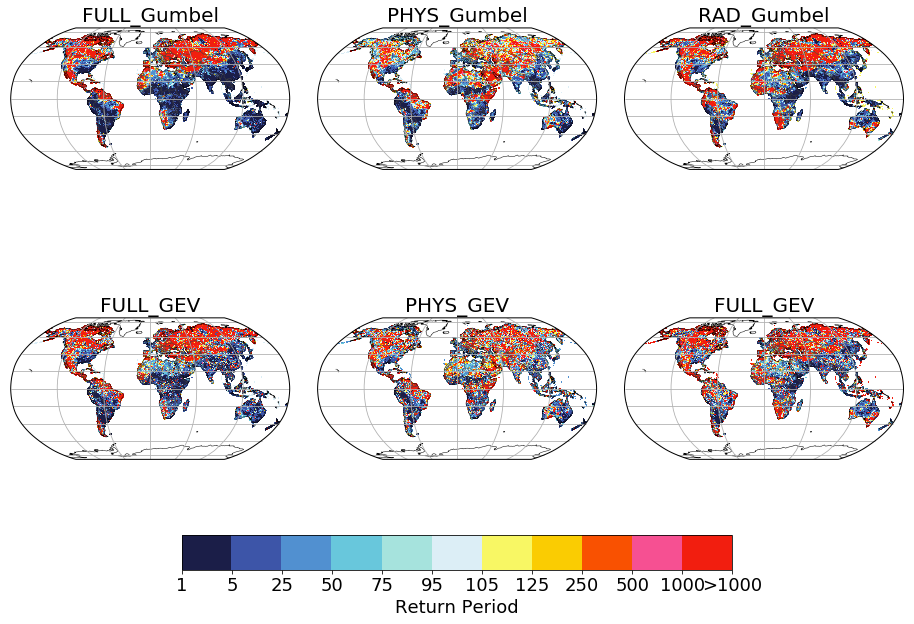

In [24]:
# --- Set up figure window --- 
fig, ax_array = plt.subplots(2,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6 = ax_array.flatten()
fig.set_size_inches(16,12)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


#Subplot 1: TFULL-Gumbel 
ax1.set_global
colorsFull_25GumbelT = np.transpose(colorsFull_25Gumbel)
contour_plot = ax1.pcolormesh(lon,lat,colorsFull_25GumbelT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax1.set_title('FULL_Gumbel')
ax1.title.set_fontsize(20)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax2.set_global
colorsPhys_25GumbelT = np.transpose(colorsPhys_25Gumbel)
contour_plot = ax2.pcolormesh(lon,lat,colorsPhys_25GumbelT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax2.set_title('PHYS_Gumbel')
ax2.title.set_fontsize(20)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


ax3.set_global
colorsRad_25GumbelT = np.transpose(colorsRad_25Gumbel)
contour_plot = ax3.pcolormesh(lon,lat,colorsRad_25GumbelT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax3.set_title('RAD_Gumbel')
ax3.title.set_fontsize(20)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# --------------- GEV --------------------- # 
ax4.set_global
colorsFull_25GEV_T = np.transpose(colorsFull_25GEV)
contour_plot = ax4.pcolormesh(lon,lat,colorsFull_25GEV_T,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax4.set_title('FULL_GEV')
ax4.title.set_fontsize(20)
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax5.set_global
colorsPhys_25GEV_T = np.transpose(colorsPhys_25GEV)
contour_plot = ax5.pcolormesh(lon,lat,colorsPhys_25GEV_T,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax5.set_title('PHYS_GEV')
ax5.title.set_fontsize(20)
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# Colorbar
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.125, ax_position.y0, ax_position.width+0.25, 0.04])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=18)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=18)  # vertically oriented colorbar


ax6.set_global
colorsRad_25GEV_T = np.transpose(colorsRad_25GEV)
contour_plot = ax6.pcolormesh(lon,lat,colorsRad_25GEV_T,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax6.set_title('FULL_GEV')
ax6.title.set_fontsize(20)
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


fig.subplots_adjust(wspace=0.1, hspace=-0.2)
